## Heteroscedastic uncertainty

### Example of learning the aleatoric heteroscedastic uncertainty by learning a simple linear regression

In [138]:
#!pip install keras==2.0.8
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, concatenate, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.initializers import RandomNormal
from keras.layers import multiply
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

First we create some samples from 0 to 10 and add some noise

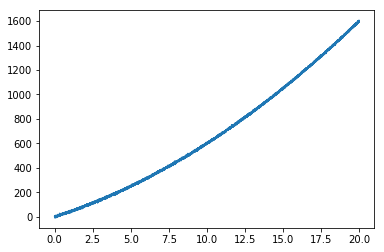

In [136]:
x = np.linspace(0, 20, 10000)#, dtype="int32")  # 100000 values between 0 and 100
delta = np.random.normal(0, 4, x.size)
x2 = np.linspace(20, 40, 10000)
delta2 = np.random.normal(0, 1, x2.size)
y = 2 * x * x2 + (delta + delta2)
plt.plot(x,y)
plt.show()

These are the function used to include the calculation of the sigmas in the loss.
Note that we use the trick of concatenating the sigma to the ouput, so the prediction is at index 0 and the sigma is at index 1 of the resulting output.

In [41]:
def aleatoric_loss(y_true, y_pred):
    sigma = y_pred[:, 1]
    epsilon = 1e-6
    y_pred_prima = y_pred[:, 0]
    output_value = ((K.square(y_pred_prima - y_true[:, 0])) / (K.square(sigma) + epsilon)) + K.log(K.square(sigma) + epsilon)
    return K.mean(output_value, axis=-1)

def aleatoric_rms(y_true, y_pred):
    y_pred_prima = y_pred[:, 0]
    return K.mean(K.square(y_pred_prima - y_true[:, 0]), axis=-1)

def aleatoric_uncertainty(y_true, y_pred):
    sigma = y_pred[:, 1]
    return K.max(K.log(K.square(sigma)), axis=-1)

In [7]:
tensorboard_cb = TensorBoard(
            log_dir='data/Uncertain_LR',
            histogram_freq=0, write_grads=True,
            write_graph=True, write_images=False, embeddings_freq=1)

First we try a model without calculating the sigma and plot some results.

Epoch 1/20
10000/10000 [==============================] - 3s 282us/step - loss: 10706.7156 - mean_squared_error: 10706.7156
Epoch 2/20
10000/10000 [==============================] - 0s 12us/step - loss: 5969.4553 - mean_squared_error: 5969.4553
Epoch 3/20
10000/10000 [==============================] - 0s 12us/step - loss: 3415.9240 - mean_squared_error: 3415.9240
Epoch 4/20
10000/10000 [==============================] - 0s 12us/step - loss: 1854.4194 - mean_squared_error: 1854.4194
Epoch 5/20
10000/10000 [==============================] - 0s 13us/step - loss: 945.0969 - mean_squared_error: 945.0969
Epoch 6/20
10000/10000 [==============================] - 0s 11us/step - loss: 451.3150 - mean_squared_error: 451.3150
Epoch 7/20
10000/10000 [==============================] - 0s 14us/step - loss: 204.0925 - mean_squared_error: 204.0925
Epoch 8/20
10000/10000 [==============================] - 0s 14us/step - loss: 90.7693 - mean_squared_error: 90.7693
Epoch 9/20
10000/10000 [===============

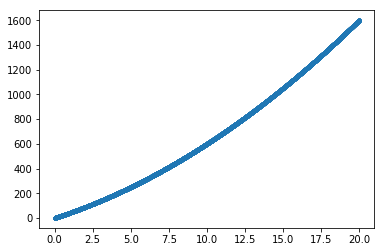

In [139]:
raw_input1 = Input(shape=(1,))
raw_input2 = Input(shape=(1,))
product = multiply([raw_input1,raw_input2])
raw_preds = Dense(1, activation='linear', name="preds")(product)

rawmodel = Model(inputs=[raw_input1,raw_input2],outputs=raw_preds)
rawmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
rawmodel.fit([x,x2], y, batch_size=128, epochs=20, shuffle=False)
raw_result = rawmodel.predict([x,x2])
plt.plot(x, raw_result[:,0],'.')
plt.show()

Then we try a model where the sigma is computed.

In [142]:
input1 = Input(shape=(1,))
input2 = Input(shape=(1,))
sigma_hidden1 = Dense(10, activation='relu', name="sigma", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)
sigma_hidden2 = Dense(5, activation='relu', name="sigma2", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)
sigma_output = Dense(1, activation='linear', name="sigma3", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)
product = multiply([input1,input2])
preds = Dense(1, activation='linear', name="preds")(product)
sigma1_hidden1 = sigma_hidden1(input1)
sigma1_hidden2 = sigma_hidden2(sigma1_hidden1)
sigma1_output = sigma_output(sigma1_hidden2)
sigma2_hidden1 = sigma_hidden1(input2)
sigma2_hidden2 = sigma_hidden2(sigma2_hidden1)
sigma2_output = sigma_output(sigma2_hidden2)
sigma = multiply([sigma1_output, sigma2_output])
aleatoric_output = concatenate([preds, sigma])
sgd = SGD(lr=0.1)
adam = Adam(lr=0.001)
rms = RMSprop(lr=0.001)
nadam = Nadam(lr=0.001)
model = Model(inputs=[input1,input2],outputs=aleatoric_output)
model.compile(optimizer=nadam, loss=aleatoric_loss, metrics=[aleatoric_rms, aleatoric_uncertainty])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
sigma (Dense)                   (None, 10)           20          input_53[0][0]                   
                                                                 input_54[0][0]                   
__________________________________________________________________________________________________
sigma2 (Dense)                  (None, 5)            55          sigma[0][0]                      
          

In [143]:
model.fit([x, x2], np.expand_dims(y, axis=1).repeat(2, axis=1), batch_size=64, epochs=300, shuffle=False)

Epoch 1/300
10000/10000 [==============================] - 2s 160us/step - loss: 88436019.2928 - aleatoric_rms: 165932.5044 - aleatoric_uncertainty: -7.0454
Epoch 2/300
10000/10000 [==============================] - 0s 30us/step - loss: 3251976.8191 - aleatoric_rms: 163836.5889 - aleatoric_uncertainty: -4.0203
Epoch 3/300
10000/10000 [==============================] - 0s 29us/step - loss: 1584933.5455 - aleatoric_rms: 162733.8725 - aleatoric_uncertainty: -3.3097
Epoch 4/300
10000/10000 [==============================] - 0s 30us/step - loss: 979571.2601 - aleatoric_rms: 161936.0451 - aleatoric_uncertainty: -2.8372
Epoch 5/300
10000/10000 [==============================] - 0s 31us/step - loss: 678777.4318 - aleatoric_rms: 161298.8900 - aleatoric_uncertainty: -2.4784
Epoch 6/300
10000/10000 [==============================] - 0s 30us/step - loss: 503424.3782 - aleatoric_rms: 160761.6032 - aleatoric_uncertainty: -2.1869
Epoch 7/300
10000/10000 [==============================] - 0s 30us/step

10000/10000 [==============================] - 0s 30us/step - loss: 3819.7143 - aleatoric_rms: 149268.8596 - aleatoric_uncertainty: 2.5531
Epoch 55/300
10000/10000 [==============================] - 0s 31us/step - loss: 3553.1190 - aleatoric_rms: 149049.3186 - aleatoric_uncertainty: 2.6234
Epoch 56/300
10000/10000 [==============================] - 0s 30us/step - loss: 3305.6509 - aleatoric_rms: 148828.2537 - aleatoric_uncertainty: 2.6935
Epoch 57/300
10000/10000 [==============================] - 0s 30us/step - loss: 3075.8688 - aleatoric_rms: 148605.9462 - aleatoric_uncertainty: 2.7635
Epoch 58/300
10000/10000 [==============================] - 0s 30us/step - loss: 2862.4558 - aleatoric_rms: 148382.1179 - aleatoric_uncertainty: 2.8334
Epoch 59/300
10000/10000 [==============================] - 0s 29us/step - loss: 2664.1928 - aleatoric_rms: 148156.6867 - aleatoric_uncertainty: 2.9031
Epoch 60/300
10000/10000 [==============================] - 0s 28us/step - loss: 2479.9696 - aleatori

10000/10000 [==============================] - 0s 29us/step - loss: 90.6400 - aleatoric_rms: 134668.3893 - aleatoric_uncertainty: 6.2387
Epoch 109/300
10000/10000 [==============================] - 0s 29us/step - loss: 85.0357 - aleatoric_rms: 134330.6486 - aleatoric_uncertainty: 6.3055
Epoch 110/300
10000/10000 [==============================] - 0s 29us/step - loss: 79.8155 - aleatoric_rms: 133989.9500 - aleatoric_uncertainty: 6.3722
Epoch 111/300
10000/10000 [==============================] - 0s 30us/step - loss: 74.9527 - aleatoric_rms: 133646.2628 - aleatoric_uncertainty: 6.4389
Epoch 112/300
10000/10000 [==============================] - 0s 29us/step - loss: 70.4233 - aleatoric_rms: 133299.3962 - aleatoric_uncertainty: 6.5055
Epoch 113/300
10000/10000 [==============================] - 0s 30us/step - loss: 66.2046 - aleatoric_rms: 132949.3020 - aleatoric_uncertainty: 6.5720
Epoch 114/300
10000/10000 [==============================] - 0s 28us/step - loss: 62.2756 - aleatoric_rms: 1

10000/10000 [==============================] - 0s 30us/step - loss: 12.0611 - aleatoric_rms: 110669.9595 - aleatoric_uncertainty: 9.5358
Epoch 162/300
10000/10000 [==============================] - 0s 29us/step - loss: 11.9727 - aleatoric_rms: 110009.9059 - aleatoric_uncertainty: 9.5854
Epoch 163/300
10000/10000 [==============================] - 0s 29us/step - loss: 11.8928 - aleatoric_rms: 109334.2278 - aleatoric_uncertainty: 9.6340
Epoch 164/300
10000/10000 [==============================] - 0s 29us/step - loss: 11.8208 - aleatoric_rms: 108641.6959 - aleatoric_uncertainty: 9.6813
Epoch 165/300
10000/10000 [==============================] - 0s 30us/step - loss: 11.7559 - aleatoric_rms: 107931.5418 - aleatoric_uncertainty: 9.7275
Epoch 166/300
10000/10000 [==============================] - 0s 28us/step - loss: 11.6975 - aleatoric_rms: 107202.1711 - aleatoric_uncertainty: 9.7722
Epoch 167/300
10000/10000 [==============================] - 0s 29us/step - loss: 11.6452 - aleatoric_rms: 1

10000/10000 [==============================] - 0s 28us/step - loss: 5.3337 - aleatoric_rms: 16.7116 - aleatoric_uncertainty: 4.2556
Epoch 216/300
10000/10000 [==============================] - 0s 29us/step - loss: 5.2343 - aleatoric_rms: 16.7212 - aleatoric_uncertainty: 4.1472
Epoch 217/300
10000/10000 [==============================] - 0s 29us/step - loss: 5.1427 - aleatoric_rms: 16.7308 - aleatoric_uncertainty: 4.0473
Epoch 218/300
10000/10000 [==============================] - 0s 29us/step - loss: 5.0563 - aleatoric_rms: 16.7397 - aleatoric_uncertainty: 3.9535
Epoch 219/300
10000/10000 [==============================] - 0s 29us/step - loss: 4.9740 - aleatoric_rms: 16.7473 - aleatoric_uncertainty: 3.8641
Epoch 220/300
10000/10000 [==============================] - 0s 29us/step - loss: 4.8948 - aleatoric_rms: 16.7535 - aleatoric_uncertainty: 3.7779
Epoch 221/300
10000/10000 [==============================] - 0s 30us/step - loss: 4.8181 - aleatoric_rms: 16.7587 - aleatoric_uncertainty:

10000/10000 [==============================] - 0s 30us/step - loss: 3.8207 - aleatoric_rms: 16.7439 - aleatoric_uncertainty: 2.8197
Epoch 271/300
10000/10000 [==============================] - 0s 30us/step - loss: 3.8206 - aleatoric_rms: 16.7439 - aleatoric_uncertainty: 2.8198
Epoch 272/300
10000/10000 [==============================] - 0s 29us/step - loss: 3.8205 - aleatoric_rms: 16.7440 - aleatoric_uncertainty: 2.8198
Epoch 273/300
10000/10000 [==============================] - 0s 35us/step - loss: 3.8205 - aleatoric_rms: 16.7440 - aleatoric_uncertainty: 2.8200
Epoch 274/300
10000/10000 [==============================] - 0s 31us/step - loss: 3.8204 - aleatoric_rms: 16.7441 - aleatoric_uncertainty: 2.8197
Epoch 275/300
10000/10000 [==============================] - 1s 50us/step - loss: 3.8205 - aleatoric_rms: 16.7447 - aleatoric_uncertainty: 2.8199
Epoch 276/300
10000/10000 [==============================] - 0s 33us/step - loss: 3.8204 - aleatoric_rms: 16.7448 - aleatoric_uncertainty:

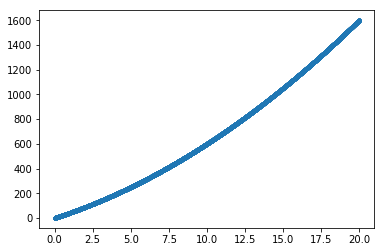

In [145]:
result = model.predict([x,x2])
plt.plot(x, result[:,0],'.')
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("si..., inputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


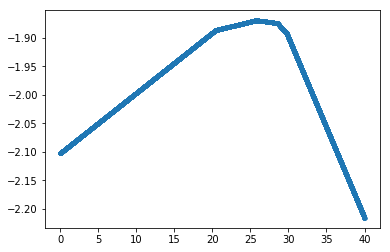

In [151]:
model_sigmas = Model(input=[input1], output=sigma1_output)
xs = np.concatenate([x,x2])
sigmas = model_sigmas.predict(xs)
sigmas
plt.plot(xs, sigmas,'.')
plt.show()